In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("themis")
library(themis)
install.packages("kknn")
library(kknn)
library(shiny)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# h3("Table 1: asdfasdf")
# mtcars
# h3("Table 2: asdfas")
# mtcars

In [3]:
#Read dataset from web
user_knowledge_data <- read_csv("https://raw.githubusercontent.com/trinityma/dsci100project/main/DDData_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN%202%20(1).csv")

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
user_knowledge_data <- user_knowledge_data |> select(STG,SCG,STR,LPR,PEG,UNS) |> mutate(UNS=as_factor(UNS))
head(user_knowledge_data)
tail(user_knowledge_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.54,0.51,0.55,0.64,0.19,Low
0.61,0.78,0.69,0.92,0.58,High
0.78,0.61,0.71,0.19,0.60,Middle
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [5]:
# 75% of the data will be in training dataset, and 25% will be in the testing dataset
set.seed(1)

user_knowledge_split <- initial_split(user_knowledge_data, prop = 0.75, strata = UNS)
user_knowledge_training <- training(user_knowledge_split)
user_knowledge_testing <- testing(user_knowledge_split)

In [6]:
# fix the class imbalance issue by oversampling the rare classes
user_knowledge_recipe <- recipe(UNS ~ STG + SCG + PEG, data = user_knowledge_training) |>
                            step_upsample(UNS, over_ratio = 1)

user_knowledge_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Up-sampling based on UNS

In [7]:
# upsampled_user_knowledge <- prep(user_knowledge_recipe) |> bake(user_knowledge_training)

# upsampled_user_knowledge |>
#   group_by(UNS) |>
#   summarize(n = n())

In [8]:
# perform 5-fold cross-validation
set.seed(1)

user_knowledge_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = "UNS")

In [9]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
knn_results <- workflow() |>
                add_recipe(user_knowledge_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = user_knowledge_vfold, grid = tibble(neighbors = 1:10)) |>
                collect_metrics()

knn_results 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7553190,5,0.025866060,Preprocessor1_Model01
1,roc_auc,hand_till,0.8314245,5,0.020025754,Preprocessor1_Model01
2,accuracy,multiclass,0.7553190,5,0.025866060,Preprocessor1_Model02
2,roc_auc,hand_till,0.8742330,5,0.012786231,Preprocessor1_Model02
3,accuracy,multiclass,0.7202256,5,0.031952345,Preprocessor1_Model03
3,roc_auc,hand_till,0.8798799,5,0.009978245,Preprocessor1_Model03
4,accuracy,multiclass,0.7203678,5,0.034984875,Preprocessor1_Model04
4,roc_auc,hand_till,0.8973792,5,0.007742239,Preprocessor1_Model04
5,accuracy,multiclass,0.7099692,5,0.031611998,Preprocessor1_Model05


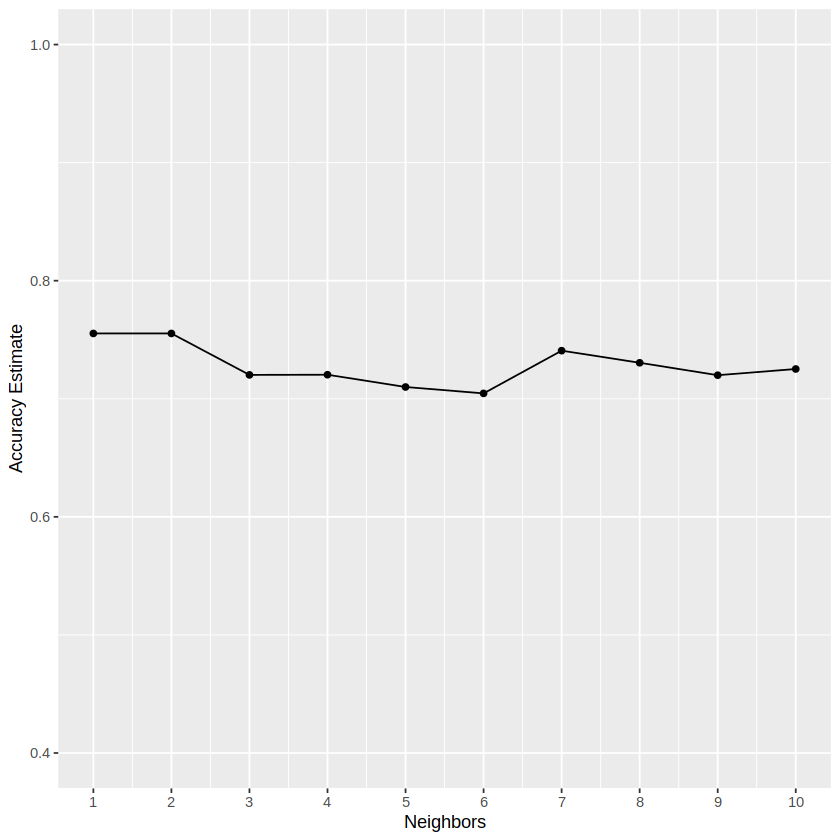

In [11]:
# find the best value for the number of neighbors
accuracies <- knn_results |>
                filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

In [12]:
# using the best k value on the training dataset to train the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

user_knowledge_fit <- workflow() |>
                        add_recipe(user_knowledge_recipe) |>
                        add_model(knn_spec) |>
                        fit(data = user_knowledge_training)

user_knowledge_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1484375
Best kernel: rectangular
Best k: 2

In [13]:
user_knowledge_test_predictions <- predict(user_knowledge_fit, user_knowledge_testing) |>
                                    bind_cols(user_knowledge_testing)

user_knowledge_test_predictions

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Middle,0.100,0.100,0.43,0.29,0.56,Middle
High,0.000,0.000,0.50,0.20,0.85,High
High,0.180,0.180,0.55,0.30,0.81,High
Low,0.060,0.060,0.51,0.41,0.30,Low
High,0.100,0.100,0.70,0.15,0.90,High
Low,0.100,0.250,0.10,0.08,0.33,Low
Middle,0.180,0.310,0.32,0.42,0.28,Low
Low,0.060,0.290,0.35,0.76,0.25,Low
High,0.090,0.300,0.68,0.18,0.85,High


In [14]:
user_knowledge_predictions_accuracy <- metrics(user_knowledge_test_predictions, truth = UNS, estimate = .pred_class)

user_knowledge_predictions_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7575758
kap,multiclass,0.6456376


In [15]:
# create a confusion matrix for the result
user_knowledge_mat <- conf_mat(user_knowledge_test_predictions, truth = UNS, estimate = .pred_class)

user_knowledge_mat

          Truth
Prediction very_low High Low Middle
  very_low        2    0   1      0
  High            0   12   0      2
  Low             2    0  15      1
  Middle          0    4   6     21